In [1]:
import json
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import numpy
from numpy.linalg import norm
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

import string
from nltk.stem.porter import *

In [75]:
f = open("./ConWea/data/nyt/coarse/seedwords.json")
nyt_seed = json.load(f)

with open("./ConWea/data/nyt/coarse/df.pkl", 'rb') as f:
    nyt_df = pickle.load(f)

In [76]:
f = open("./ConWea/data/20news/coarse/seedwords.json")
news_seed = json.load(f)

with open("./ConWea/data/20news/coarse/df.pkl", 'rb') as f:
    news_df = pickle.load(f)

In [77]:
#fine
f = open("./ConWea/data/nyt/fine/seedwords.json")
nyt_seed_fine = json.load(f)

with open("./ConWea/data/nyt/fine/df.pkl", 'rb') as f:
    nyt_df_fine = pickle.load(f)
    
f = open("./ConWea/data/20news/fine/seedwords.json")
news_seed_fine = json.load(f)

with open("./ConWea/data/20news/fine/df.pkl", 'rb') as f:
    news_df_fine = pickle.load(f)
    
X_train_news_fine = news_df_fine.sentence.tolist()
X_train_nyt_fine = nyt_df_fine.sentence.tolist()

In [78]:
X_train_news = news_df.sentence.tolist()
X_train_nyt = nyt_df.sentence.tolist()

### TF_IDF

In [7]:
# tfidf_vectorizer = TfidfVectorizer()
# tokenizer = tfidf_vectorizer.build_tokenizer()
# punct = string.punctuation
# stemmer = PorterStemmer()

# t = t.lower() # lowercase string
# t = [c for c in t if not (c in punct)] # non-punct characters
# t = ''.join(t) # convert back to string
# words = t.strip().split() # tokenizes
# for w in words:
#     #w = stemmer.stem(w)
#     totalWords += 1
#     wordCount[w] += 1

In [62]:
# seed_example = list(nyt_seed.values())
# seed_example_doc = [' '.join(i) for i in seed_example]
# seed_example_doc

# token_X(seed_example_doc)

In [42]:
#token_news = token_X(X_train_news)

In [193]:
def token_X(X_train):
    
    tfidf_vectorizer = TfidfVectorizer()
    tokenizer = tfidf_vectorizer.build_tokenizer()
    
    punct = string.punctuation
    stemmer = PorterStemmer()
    
    X_token = []
    for doc in X_train:
        doc = doc.lower()
        doc = [i for i in doc if not (i in punct)] # non-punct characters
        doc = ''.join(doc) # convert back to string
        words = tokenizer(doc) # tokenizes
        for i in range(len(words)): #stemmer
            words[i] = stemmer.stem(words[i])
        X_token.append(words)
    
    return X_token

In [194]:
for clas in nyt_seed:
    cla_lis = nyt_seed[clas]
    new_lis = token_X([' '.join(cla_lis)])[0]
    nyt_seed[clas] = new_lis

for clas in news_seed:
    cla_lis = news_seed[clas]
    new_lis = token_X([' '.join(cla_lis)])[0]
    news_seed[clas] = new_lis

In [195]:
def get_idf(token):

    dic_idf = defaultdict(int)
    for doc in token:
        unique_token = set(doc)
        for w in unique_token:
            dic_idf[w] += 1
    return dic_idf
            

In [197]:
def get_tfidf_stat(X_train, doc, seeds, idf_dic): #the passed in doc is already tokenized
    sum_tfidf = 0
    
    dic_tfidf = defaultdict(int)
    
    for w in doc:
        dic_tfidf[w] += 1
        
    counter = 0
    for s in seeds:
        if s in idf_dic:
            #print("yeahhh")
            counter += 1
            dic_tfidf[s] = dic_tfidf[s] * numpy.log((len(X_train) / idf_dic[s]))
        else:
            #print("no way..")
            dic_tfidf[s] = 0
        sum_tfidf += dic_tfidf[s] 
        
    return sum_tfidf / counter
    

In [198]:
def get_class(X_train, doc, seeds_dic, idf_dic):
    dic_scores = defaultdict(int)
    for c in list(seeds_dic.keys()):
        tfidf = get_tfidf_stat(X_train, doc, seeds_dic[c], idf_dic)
        dic_scores[c] = tfidf
    if len(set(list(dic_scores.values()))) == 1: 
        if int(list(set(list(dic_scores.values())))[0]) == 0: #having tie: all 0 case
            return "no_label"
        else: #having tie: 
            return list(dic_scores.keys())[0]
    return max(dic_scores, key=dic_scores.get)

In [199]:
def get_prediction(X_train, seeds_dic):
    token = token_X(X_train) #call token func only once
    idf_dic = get_idf(token)
    prediction = []
    for doc in token:
        prediction.append(get_class(X_train, doc, seeds_dic, idf_dic))
    return prediction

In [200]:
def get_accuracy(df, X_train, seeds_dic):
    prediction = get_prediction(X_train, seeds_dic)
    
    #print('Accuracy: ', accuracy_score(news_df.label.tolist(), news_prediction, normalize=False))
    print('F1-score micro: ', f1_score(df.label, prediction, average='micro'))
    print('F1-score macro: ', f1_score(df.label, prediction, average='macro'))
    

In [201]:
get_accuracy(nyt_df, X_train_nyt, nyt_seed)

F1-score micro:  0.5639802203522165
F1-score macro:  0.4495408343041065


In [202]:
get_accuracy(news_df, X_train_news, news_seed)

F1-score micro:  0.4335396242948683
F1-score macro:  0.4724983248391604


In [ ]:
get_accuracy(news_df_fine, X_train_news_fine, news_seed_fine)

In [ ]:
get_accuracy(nyt_df_fine, X_train_nyt_fine, nyt_seed_fine)

Challenge: using the package / the right formula of tfidf / merely dividing tf by #document with word's occurence: all have approximately the same f1 score: all four socres are below the scores in table.

Maybe it make sense to get a slightly lower score? (since they might be using more advanced parameter tunning?)

## word2vec

##### Word2Vec algorithm learn a vector representation for each word averages the word vectors of all the words present in a particular sentence to generate the document vector for that sentence

adopt the word_vec to doc_vec tech from this: https://blog.eduonix.com/artificial-intelligence/converting-word-vectors-document-vectors-using-gensim-library/

In [80]:
!python -m pip install -U gensim

Error processing line 1 of /Users/xiangzairan/opt/anaconda3/lib/python3.8/site-packages/google_api_core-2.0.1-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "/Users/xiangzairan/opt/anaconda3/lib/python3.8/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 553, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
Error processing line 1 of /Users/xiangzairan/opt/anaconda3/lib/python3.8/site-packages/google_auth-2.2.1-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "/Users/xiangzairan/opt/anaconda3/lib/python3.8/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 553, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
Error processing line 1 of /Users/xiangzairan/opt/anac

In [177]:
#!python -m pip install -U gensim

from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [203]:

def token_X(X_train):
    
    tfidf_vectorizer = TfidfVectorizer()
    tokenizer = tfidf_vectorizer.build_tokenizer()
    
    punct = string.punctuation
    stemmer = PorterStemmer()
    
    X_token = []
    for doc in X_train:
        doc = doc.lower()
        doc = [i for i in doc if not (i in punct)] # non-punct characters
        doc = ''.join(doc) # convert back to string
        words = tokenizer(doc) # tokenizes
        for i in range(len(words)): #stemmer
            words[i] = stemmer.stem(words[i])
        X_token.append(words)
    
    return X_token

In [204]:
for clas in nyt_seed:
    cla_lis = nyt_seed[clas]
    new_lis = token_X([' '.join(cla_lis)])[0]
    nyt_seed[clas] = new_lis

for clas in news_seed:
    cla_lis = news_seed[clas]
    new_lis = token_X([' '.join(cla_lis)])[0]
    news_seed[clas] = new_lis

In [205]:
def get_token_wordDic(X_train):
     
    #preparing model and word dic 

    print("tokenizing...")
    token_list = token_X(X_train) #2D array with word in each document
    
    model = Word2Vec(sentences=token_list, vector_size=100, window=5, min_count=1, workers=4) #use vector size 500
    model.save("word2vec.model")
    
    print("getting the vector for each word...")
    #save word vector in a dictionary
    word_dic = dict({})
    for idx, key in enumerate(model.wv.key_to_index):
        word_dic[key] = model.wv[key]
        
    return token_list, word_dic


In [206]:
def get_all_document_vector(X_train, token_document, word_dic):
    
    #starting vectorizing for each document
    print("getting the vector for each document...")
    DocVec = []
    for doc in token_document: #for each document
        doc_vec = numpy.array(100)
        counter = 0
        for word in doc: #for each word
            if word in word_dic.keys():
                counter += 1
                doc_vec = numpy.add(doc_vec, word_dic[word]) #add word vectors
        doc_vec = numpy.divide(doc_vec, counter) #divide by #of words in document (w/ vector)
        DocVec.append(doc_vec)
        
    return DocVec #return the vector representation of the all the document in a dict

In [207]:
def get_seed_vector(X_train, seed, seed_class, word_dic):
    
    doc = seed[seed_class]
    SeedVec = numpy.array(100)
    num_seed = 0
    for word in doc: #for each seed word
        if word in word_dic.keys():
            num_seed += 1
            SeedVec = numpy.add(SeedVec, word_dic[word]) #add seed vectors
    if num_seed != 0:     
        SeedVec = numpy.divide(SeedVec, num_seed) #divide by #of seed words
    
    return SeedVec

In [208]:
nyt_seed

{'arts': ['music', 'orchestra', 'album', 'opera', 'ballet'],
 'business': ['compani', 'euro', 'economi', 'batteri', 'sale'],
 'science': ['space', 'research', 'scientist', 'research', 'scienc'],
 'sports': ['yank', 'cup', 'leagu', 'basketb', 'golf'],
 'politics': ['republican', 'senat', 'senat', 'democrat', 'elect']}

In [209]:
def get_cosin(doc_vector, class_vector):
    return numpy.dot(doc_vector,class_vector)/(norm(doc_vector)*norm(class_vector))

In [210]:
def get_prediction_word2vec(X_train, seeds_dic):
    
    print("getting the word dict...")
    token_document, word_dic = get_token_wordDic(X_train) #get the word dict
    
    prediction = []
    
    All_DocVec = get_all_document_vector(X_train, token_document, word_dic)#get all document vector
    
    print("getting the prediction...")
    
    for doc_vector in All_DocVec: #for each document, find the class with greatest similarity
        max_class = "none"
        max_similarity = -1000
        for cla in list(seeds_dic.keys()): 
            similarity = get_cosin(doc_vector, get_seed_vector(X_train, seeds_dic, cla, word_dic))
            if similarity >= max_similarity:
                max_similarity = similarity
                max_class = cla
        prediction.append(max_class) #append the prediction 
    
    return prediction
        

In [110]:
token_document, word_dic = get_token_wordDic(X_train_nyt) #get the word dict
All_DocVec = get_all_document_vector(X_train_nyt, token_document, word_dic)#get all document vector

tokenizing...
getting the vector for each word...
getting the vector for each document...


In [176]:
prediction = get_prediction_word2vec(X_train_nyt, nyt_seed)
len(prediction)

getting the word dict...
tokenizing...
getting the vector for each word...
getting the vector for each document...
getting the prediction...


11527

In [211]:
def get_accuracy_word2vec(df, X_train, seeds_dic):
    prediction = get_prediction_word2vec(X_train, seeds_dic)
    
    print("calculating f1 scores...")
    print('F1-score micro: ', f1_score(df.label, prediction, average='micro'))
    print('F1-score macro: ', f1_score(df.label, prediction, average='macro'))

In [212]:
get_accuracy_word2vec(nyt_df, X_train_nyt, nyt_seed)

getting the word dict...
tokenizing...
getting the vector for each word...
getting the vector for each document...
getting the prediction...
calculating f1 scores...
F1-score micro:  0.8001214539776178
F1-score macro:  0.41701601724716914


In [213]:
get_accuracy_word2vec(news_df, X_train_news, news_seed)

getting the word dict...
tokenizing...
getting the vector for each word...
getting the vector for each document...
getting the prediction...
calculating f1 scores...
F1-score micro:  0.40511528561257454
F1-score macro:  0.2922659659402966


In [45]:
get_accuracy_word2vec(nyt_df_fine, X_train_nyt_fine, nyt_seed_fine)

===============getting the word dict===============
===============finished getting the word dict===============
===============getting the vector for each document===============
===============finished getting the vector for each document===============
===============getting the prediction===============
===============finished getting the prediction ===============
=============== calculating f1 scores ===============
F1-score micro:  0.2975622451635291
F1-score macro:  0.12470350277214161


In [46]:
get_accuracy_word2vec(news_df_fine, X_train_news_fine, news_seed_fine)

===============getting the word dict===============
===============finished getting the word dict===============
===============getting the vector for each document===============
===============finished getting the vector for each document===============
===============getting the prediction===============
===============finished getting the prediction ===============
=============== calculating f1 scores ===============
F1-score micro:  0.1626595103784435
F1-score macro:  0.09602379526257246


### Table and Visualization

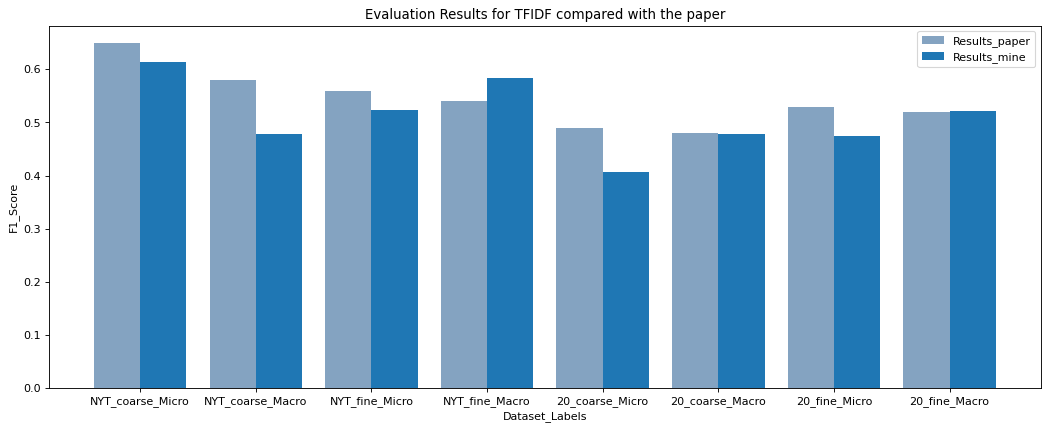

In [64]:
figure(figsize=(16, 6), dpi=80)

X = ['NYT_coarse_Micro','NYT_coarse_Macro','NYT_fine_Micro','NYT_fine_Macro', 
     '20_coarse_Micro','20_coarse_Macro','20_fine_Micro','20_fine_Macro']
Yprof = [0.65,0.58,0.56,0.54, 0.49, 0.48, 0.53, 0.52]
Zmine = [0.6132558341285677,0.4779442676323146,0.5234666435325757,0.5846423323703109, 
        0.4075798236486116, 0.477963597229988, 0.475162933347938, 0.5222694644735252]
    
X_axis = numpy.arange(len(X))
  
plt.bar(X_axis - 0.2, Yprof, 0.4, label = 'Results_paper', color = (0.2, 0.4, 0.6, 0.6))
plt.bar(X_axis + 0.2, Zmine, 0.4, label = 'Results_mine')
  
plt.xticks(X_axis, X)
plt.xlabel("Dataset_Labels")
plt.ylabel("F1_Score")
plt.title("Evaluation Results for TFIDF compared with the paper")
plt.legend()
plt.show()

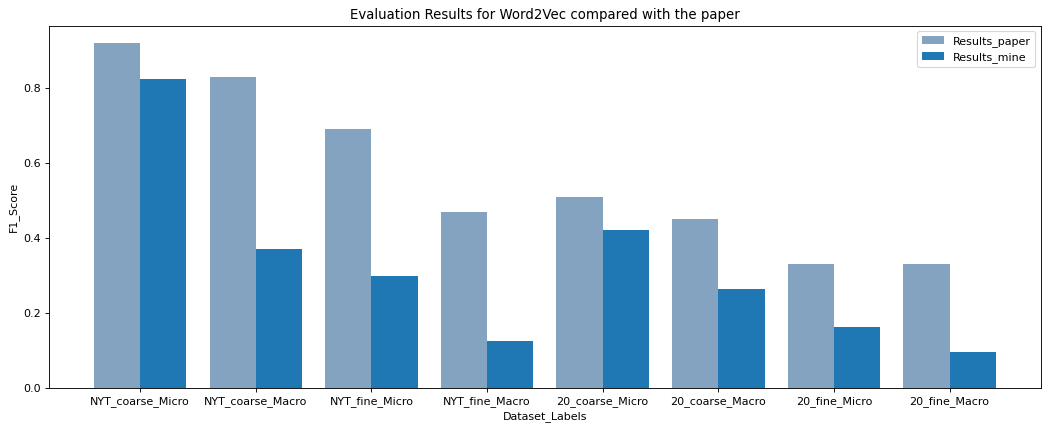

In [65]:
figure(figsize=(16, 6), dpi=80)

X = ['NYT_coarse_Micro','NYT_coarse_Macro','NYT_fine_Micro','NYT_fine_Macro', 
     '20_coarse_Micro','20_coarse_Macro','20_fine_Micro','20_fine_Macro']
Yprof = [0.92, 0.83, 0.69, 0.47, 0.51, 0.45, 0.33, 0.33]
Zmine = [0.824065238136549, 0.36945673089377234, 0.2975622451635291, 0.12470350277214161, 
        0.4222575168410099, 0.26248156832842173, 0.1626595103784435, 0.09602379526257246]
    
X_axis = numpy.arange(len(X))
  
plt.bar(X_axis - 0.2, Yprof, 0.4, label = 'Results_paper',  color = (0.2, 0.4, 0.6, 0.6))
plt.bar(X_axis + 0.2, Zmine, 0.4, label = 'Results_mine')
  
plt.xticks(X_axis, X)
plt.xlabel("Dataset_Labels")
plt.ylabel("F1_Score")
plt.title("Evaluation Results for Word2Vec compared with the paper")
plt.legend()
plt.show()

In [60]:
data = [['TFIDF', 0.6132558341285677,0.4779442676323146,0.5234666435325757,0.5846423323703109, 
        0.4075798236486116, 0.477963597229988, 0.475162933347938, 0.5222694644735252], 
       ['Word2Vec', 0.824065238136549, 0.36945673089377234, 0.2975622451635291, 0.12470350277214161, 
        0.4222575168410099, 0.26248156832842173, 0.1626595103784435, 0.09602379526257246]
       ]

df_result = pd.DataFrame(data, columns = ['Model','NYT_coarse_Micro','NYT_coarse_Macro','NYT_fine_Micro','NYT_fine_Macro', 
     '20_coarse_Micro','20_coarse_Macro','20_fine_Micro','20_fine_Macro']).set_index('Model')
df_result


,NYT_coarse_Micro,NYT_coarse_Macro,NYT_fine_Micro,NYT_fine_Macro,20_coarse_Micro,20_coarse_Macro,20_fine_Micro,20_fine_Macro
Model,,,,,,,,
TFIDF,0.613256,0.477944,0.523467,0.584642,0.407580,0.477964,0.475163,0.522269
Word2Vec,0.824065,0.369457,0.297562,0.124704,0.422258,0.262482,0.162660,0.096024


In [62]:
#compared with the result on the paper
data_paper = [['TFIDF',0.65,0.58,0.56,0.54, 0.49, 0.48, 0.53, 0.52],
       ['Word2Vec', 0.92, 0.83, 0.69, 0.47, 0.51, 0.45, 0.33, 0.33]]

df_result_paper = pd.DataFrame(data_paper, columns = ['Model','NYT_coarse_Micro','NYT_coarse_Macro','NYT_fine_Micro','NYT_fine_Macro', 
     '20_coarse_Micro','20_coarse_Macro','20_fine_Micro','20_fine_Macro']).set_index('Model')
df_result_paper


,NYT_coarse_Micro,NYT_coarse_Macro,NYT_fine_Micro,NYT_fine_Macro,20_coarse_Micro,20_coarse_Macro,20_fine_Micro,20_fine_Macro
Model,,,,,,,,
TFIDF,0.65,0.58,0.56,0.54,0.49,0.48,0.53,0.52
Word2Vec,0.92,0.83,0.69,0.47,0.51,0.45,0.33,0.33


### thoughts

TFIDF: The f1 score is slightly below the ones on paper, but I guess that is to be expected. The overall trend agrees with the paper (as shown in the bar chart)

I am guessing the difference might be caused by how I handle the case when the TF-IDF score for all classes is 0. I created a new label called "no label" for those documents with TF-IDF equals = 0 for all classes (and we can count that as a wrong prediction), and choose the last class label if we have a tie in the TF-IDF. The authors of the paper might be handling this case differently and thus cause this slight difference. I believe there are quite a few documents withTF-IDF all equal to 0 for all classes.


Word2Vec: the f1 scores are close to the ones on the paper only in NYT_coarse_Micro and 20_coarse_Micro, and are way lower in other cases (as shown in the bar chart). The two reasonable Micro scores might tell something about this model, but I am not sure what that is. It is also quite confusing why Macro scores are much lower since macro f1 should be straightforward. The f1 scores for all fine datasets are from 0.1 to 0.3, which is a lot lower than what was expected (about 0.3 to 0.6). Not sure why either here.

The trend of my f1 score agrees with the paper, at least, as illustrated in the bar chart. It might mean that the model is working properly (with no major issues), but is performing a bit worse than expected. 